In [2]:
import numpy as np

In [9]:
# fitness function
def fitness_val(der_ale,A,zP1,O):
    z_i = zP1 + np.matmul(A,der_ale)
    z_sq = np.square(z_i-O)
    w = np.ravel(np.exp(-np.sum(z_sq,axis=0))) #np.ravel to flatten matrix into a 1D array
    #log_w = np.log(w)
    return w

In [10]:
# hybridisation simulation with chance of choosing parent proportional to their fitness
def hybridisation_proportional_fitness(P1,P2,N,A,zP1,O,seedValue):
    rng = np.random.default_rng(seedValue)
    G = 1 #number of generations
    D = P1.shape[0]
    P1 = np.matrix(P1); P2 = np.matrix(P2)
    P1_fit = fitness_val(P1,A,zP1,O)
    P1_choice = np.random.choice(range(N),N,replace=True,p=(P1_fit)/sum(P1_fit))
    S1 = np.zeros([D,1])
    for i in P1_choice:
        s = P1[:,i]
        S1 = np.concatenate((S1,s),axis=1)
    S1 = np.delete(S1,0,1)
    P2_fit = fitness_val(P2,A,zP1,O)
    P2_choice = np.random.choice(range(N),N,replace=True,p=(P2_fit)/sum(P2_fit))
    # sample from the new population with replacement
    S2 = np.zeros([D,1])
    for i in P2_choice:
        s = P2[:,i]
        S2 = np.concatenate((S2,s),axis=1)
    S2 = np.delete(S2,0,1)

    np.place(S1,S1 == 1,rng.binomial(1,0.5,[D,N])*2)
    np.place(S2,S2 == 1,rng.binomial(1,0.5,[D,N])*2)
    F = np.matrix((S1 + S2)/2)

    while 1 in F:
        # sample two parental populations from the new population with replacement. Probability proportional to fitness
        F_fit_1 = fitness_val(F,A,zP1,O)
        P1_choice = np.random.choice(range(N),N,replace=True,p=(F_fit_1)/sum(F_fit_1))
        S1 = np.zeros([D,1])
        for i in P1_choice:
            s = F[:,i]
            S1 = np.concatenate((S1,s),axis=1)
        S1 = np.delete(S1,0,1)
        F_fit_2 = fitness_val(F,A,zP1,O)
        P2_choice = np.random.choice(range(N),N,replace=True,p=(F_fit_2)/sum(F_fit_2))
        # sample from the new population with replacement
        S2 = np.zeros([D,1])
        for i in P2_choice:
            s = F[:,i]
            S2 = np.concatenate((S2,s),axis=1)
        S2 = np.delete(S2,0,1)
        # a new hybridisation
        np.place(S1,S1 == 1,rng.binomial(1,0.5,[D,N])*2)
        np.place(S2,S2 == 1,rng.binomial(1,0.5,[D,N])*2)
        F = (S1 + S2)/2
        G += 1
        #print(f"F {G}")
        #print(F)
    H = np.mean(F)/2
    F_log_fit = np.log(fitness_val(F,A,zP1,O)[0])
    return F, G, H, F_log_fit

# Simulating hybridisation in the background of evolutionary divergence

Random mutation model. Each of the two hybridising populations have acquired mutations that affect traits by coefficients that follow a normal distribution.

P1 and P2 have each fixed random mutations at D/2 sites. Each mutation affects each of the n traits of an individual by a coefficient that is normally distributed. For comparison between scenarios, we fix the value of selection coefficient of each individual mutations, $s_i$.

Details on fixing $s_i$:

For any particular locus $i$, the selection coefficient is
$$
s_{i}\approx -4\sum_{j=1}^{n}a_{ij}^2
$$
For scaling, we set the scaling factor $r$ as
$$
4r^{2} = -s_{i}
$$
Since selection is effective when $N|s|>1$, and $|s| \geq \sum_{i=1}^{D}|s_{i}|$, we need to have
$$
r^2 \geq \frac{1}{4ND}
$$
for selection to be effective.

In [4]:
rng = np.random.default_rng(seed=211)

n = 11; D = 10; N = 200

D_h = int(D/2)
# generate normally distributed random numbers for mutations. m for P1 and l for P2.
m = rng.normal(loc=0,scale=0.5,size=[D_h,n])
l = rng.normal(loc=0,scale=0.5,size=[D_h,n])

#choose scaling factor
r = np.sqrt(1/(4*N*D))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s| >= {4*r**2*D*N}")

r = 0.011180339887498949
target s_i =-0.0005
target N|s| >= 1.0


In [11]:
# a function to normalise and then scale them
def scaling(r,a,D,n):
    # calculate the magnitude of rows in the random number matrix a
    a_square = np.square(a)
    a_row_mag = np.sqrt(np.sum(a_square,axis=1))
    # scale each row by its magnitude
    mag_matx = np.reshape(np.repeat(a_row_mag,repeats=n,axis=0),newshape=[D,n])
    #print(mag_matx)
    unit_matx = np.divide(a,mag_matx)
    # rescale it to have a magnitude of r^2
    A = r*unit_matx
    return A

# scale m and l using the function above
M = scaling(r,m,D_h,n)
L = scaling(r,l,D_h,n)
print(f"M\n{M}")
print(f"L\n{L}")
#check that it indeed has a magnitude of r^2
M_mag = np.sum(np.square(M),axis=1)
print(f"sum of square of each row \n{M_mag}")


M
[[ 0.01112599  0.00185876  0.00656189 -0.00168593 -0.00381226  0.00429105
   0.00262659 -0.00090358  0.00529133  0.00286298]
 [ 0.00308702 -0.00455304  0.00246599  0.00305933 -0.00248708  0.00691043
   0.01157906  0.00384553  0.00102383 -0.00067009]
 [ 0.01001454 -0.00103338 -0.00699021  0.00060138  0.00152336 -0.00171414
   0.00056924  0.0042015   0.00382812 -0.00784388]
 [-0.00098311  0.00125677 -0.00012158 -0.00137214  0.00248459  0.01177038
   0.00275989 -0.00885279  0.00312624 -0.00225368]
 [ 0.00230011 -0.00247393 -0.00892095  0.00297597  0.00473162 -0.00019461
   0.01049805 -0.00066155  0.00389172  0.00138961]]
L
[[-5.93721886e-03  4.22038363e-03  1.06111425e-06  7.56570289e-03
   3.45605857e-03  5.23543382e-03 -8.73412443e-04  8.95738105e-03
  -1.72384220e-03 -4.04656251e-03]
 [-1.04011257e-03  6.20732350e-03  9.72522945e-03 -3.55085492e-05
  -1.45025916e-03 -2.14134272e-03 -1.51590479e-03  8.83540827e-03
   4.99438172e-03  1.95220299e-03]
 [ 2.35182385e-03  2.70384957e-03  1

Let us arrange the gene loci of all the mutation such that the ones fixed in P1 come first. In this case, the individual trait values for a P1 individual will be:
$$
z_{P1,j} = 2\sum_{i=1}^{D/2}m_{ij}
$$

In [6]:
zP1_vec = 2*np.sum(M,axis=0)
print(zP1_vec)
print(zP1_vec.shape)
zP1 = np.reshape(np.repeat(zP1_vec,repeats=N,axis=0),newshape=[n,N])
print(zP1.shape)

[-0.01708256 -0.01485583 -0.02297821  0.02060591  0.00514029 -0.02082413
  0.02364064  0.008091    0.00167015 -0.01188978  0.00385055]
(11,)
(11, 200)


The A matrix will be:

In [7]:
A = np.concatenate((-1*M,L),axis=0)
print(f"A\n{A}")
print(A.shape)

A
[[ 3.70946697e-03  8.12660354e-05  3.26415966e-03 -1.10480256e-03
  -1.84041049e-03  5.26398306e-03 -2.69151775e-03 -3.21755493e-03
   7.00642799e-03  4.17566896e-04 -1.18320430e-03]
 [-9.12345029e-04  8.20447346e-04  2.79422303e-03  1.14767869e-03
   3.98527397e-04 -1.59818619e-04 -3.14154608e-03 -6.99338225e-03
  -2.31671512e-03 -4.91293339e-03 -5.08964512e-03]
 [ 5.80121873e-04 -1.88598772e-03  3.99452911e-03 -5.72270029e-03
  -2.24596453e-03  1.04558406e-03 -6.76750405e-03 -3.87681523e-03
  -3.31255609e-04  2.06206200e-03  1.03571594e-03]
 [ 4.20033584e-03  9.94153779e-04  3.08517711e-03 -1.50738303e-03
  -2.05801854e-04  3.51969827e-03  1.72493816e-03  8.18703028e-03
  -2.39912331e-03  2.26382979e-03  1.12431794e-03]
 [ 9.63699644e-04  7.41803782e-03 -1.64898395e-03 -3.11574725e-03
   1.32350451e-03  7.42619612e-04 -9.44688492e-04  1.85522132e-03
  -2.79440977e-03  6.11436635e-03  2.18754120e-03]
 [ 2.46718896e-03 -2.81745650e-03  1.30098491e-04 -2.39408245e-03
  -3.05326360e-03

The ancestral phenotype do not carry any of the mutations in P1 or P2. Therefore, the ancestral genotype will have the P2 genotype at loci where P1 has fixed a mutation and the P1 genotype at loci where P2 has fixed a mutation. Under our arrangement, the ancestral genotype would be:

In [8]:
G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
print(G_an)

[[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


The ancestral phenotype is set as optimum. Test:

In [9]:
O = np.zeros([n,N])
anc_fit = fitness_val(G_an,A.T,zP1,O)
print(anc_fit)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


We then test if the outcome of hybridisation resembles the ancestor using this particular $A$ and $z_{WT}$.

In [10]:
n = 11; D = 10; N = 200

P1 = np.zeros([D,N]); P2 = np.full([D,N],2)


w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
print(f"final population {w[0]}")
print(f"no. of generations to fixation {w[1]}")
print(f"hybridisation index (H){w[2]}")

final population [[0. 0. 0. ... 0. 0. 0.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [2. 2. 2. ... 2. 2. 2.]
 [0. 0. 0. ... 0. 0. 0.]]
no. of generations to fixation 1543
hybridisation index (H)0.5


# Using a stronger selection coefficient

In [11]:
# the above example should be repeated with a stronger selection coefficient to see quasi-deterministic effect
rng = np.random.default_rng(seed=211)

n = 11; D = 10; N = 500

D_h = int(D/2)
# generate normally distributed random numbers for mutations. m for P1 and l for P2. Standard normal distribution.
m = rng.normal(loc=0,scale=1,size=[D_h,n])
l = rng.normal(loc=0,scale=1,size=[D_h,n])

#choose scaling factor so that N*|s|~5
s_target = 20
r = np.sqrt(s_target/(4*N*D))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s| ～ {4*r**2*D*N}")

M = scaling(r,m,D_h,n)
L = scaling(r,l,D_h,n)

zP1_vec = 2*np.sum(M,axis=0)
#print(zP1_vec)
zP1 = np.reshape(np.repeat(zP1_vec,repeats=N,axis=0),newshape=[n,N])
#print(zP1.shape)

A = np.concatenate((-1*M,L),axis=0)
#print(f"A\n{A}")
#print(A.shape)

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)

repeats = 4
for k in range(1,repeats+1):
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    print(f"final population {w[0]}")
    print(f"no. of generations to fixation {w[1]}")
    print(f"hybridisation index (H){w[2]}")


r = 0.03162277660168379
target s_i =-0.003999999999999999
target N|s| ～ 19.999999999999996
Simulation 1
final population [[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [2. 2. 2. ... 2. 2. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
no. of generations to fixation 3496
hybridisation index (H)0.6
Simulation 2
final population [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [2. 2. 2. ... 2. 2. 2.]
 [0. 0. 0. ... 0. 0. 0.]]
no. of generations to fixation 3621
hybridisation index (H)0.4
Simulation 3
final population [[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]]
no. of generations to fixation 2423
hybridisation index (H)0.8
Simulation 4
final population [[0. 0. 0. ... 0. 0. 0.]
 [2. 2. 2. ... 2. 2. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [

In [13]:
p1_fit = fitness_val(P1,A.T,zP1,O)
print(p1_fit[0])
p2_fit = fitness_val(P2,A.T,zP1,O)
print(p2_fit[0])


0.9785650224348427
0.9788415083000297


In [13]:
# the above example should be repeated with a stronger selection coefficient to see quasi-deterministic effect
rng = np.random.default_rng(seed=214)

n = 10; D = 10; N = 500
#choose scaling factor so that N*|s|~5
s_i_target = 0.5
r = np.sqrt(s_i_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| ～ {4*r**2*N}")

D_h = int(D/2)
# generate normally distributed random numbers for mutations. m for P1 and l for P2. Standard normal distribution.
m = rng.normal(loc=0,scale=1,size=[D_h,n])
l = rng.normal(loc=0,scale=1,size=[D_h,n])

M = scaling(r,m,D_h,n)
L = scaling(r,l,D_h,n)

zP1_vec = 2*np.sum(M,axis=0)
#print(zP1_vec)
zP1 = np.reshape(np.repeat(zP1_vec,repeats=N,axis=0),newshape=[n,N])
#print(zP1.shape)

A = np.concatenate((-1*M,L),axis=0)
#print(f"A\n{A}")
#print(A.shape)

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)
P1_log_fit = np.log(fitness_val(P1,A.T,zP1,O))
P2_log_fit = np.log(fitness_val(P2,A.T,zP1,O))
print(f"log fitness of P1 is {P1_log_fit[0]}")
print(f"log fitness of P2 is {P2_log_fit[0]}")

repeats = 4
for k in range(1,repeats+1):
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    print(f"final population {w[0]}")
    print(f"no. of generations to fixation {w[1]}")
    print(f"hybridisation index (H){w[2]}")
    print(f"log fitness of final population {w[3]}")

r = 0.015811388300841896
target s_i =-0.0009999999999999998
target N|s_i| ～ 0.4999999999999999
log fitness of P1 is -0.009267494341431782
log fitness of P2 is -0.005155542641588749
Simulation 1
final population [[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]]
no. of generations to fixation 1882
hybridisation index (H)0.7
log fitness of final population -0.0048066873808623655
Simulation 2
final population [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 2. 2. ... 2. 2. 2.]]
no. of generations to fixation 3354
hybridisation index (H)0.4
log fitness of final population -0.002468913653368496
Simulation 3
final population [[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
no. of generations to fixa

In [21]:
# the above example should be repeated with a stronger selection coefficient to see quasi-deterministic effect
rng = np.random.default_rng(seed=214)

n = 10; D = 10; N = 500
#choose scaling factor so that N*|s|~5
s_i_target = 2
r = np.sqrt(s_i_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| ～ {4*r**2*N}")

D_h = int(D/2)
# generate normally distributed random numbers for mutations. m for P1 and l for P2. Standard normal distribution.
m = rng.normal(loc=0,scale=1,size=[D_h,n])
l = rng.normal(loc=0,scale=1,size=[D_h,n])

M = scaling(r,m,D_h,n)
L = scaling(r,l,D_h,n)

zP1_vec = 2*np.sum(M,axis=0)
#print(zP1_vec)
zP1 = np.reshape(np.repeat(zP1_vec,repeats=N,axis=0),newshape=[n,N])
#print(zP1.shape)

A = np.concatenate((-1*M,L),axis=0)
#print(f"A\n{A}")
#print(A.shape)

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)
P1_log_fit = np.log(fitness_val(P1,A.T,zP1,O))
P2_log_fit = np.log(fitness_val(P2,A.T,zP1,O))
print(f"log fitness of P1 is {P1_log_fit[0]}")
print(f"log fitness of P2 is {P2_log_fit[0]}")



r = 0.03162277660168379
target s_i =-0.003999999999999999
target N|s_i| ～ 1.9999999999999996
log fitness of P1 is -0.037069977365727154
log fitness of P2 is -0.02062217056635494


In [22]:
repeats = 4
for k in range(1,repeats+1):
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    print(f"final population {w[0]}")
    print(f"no. of generations to fixation {w[1]}")
    print(f"hybridisation index (H){w[2]}")
    print(f"log fitness of final population {w[3]}")

Simulation 1
final population [[2. 2. 2. ... 2. 2. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [2. 2. 2. ... 2. 2. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 2. 2. ... 2. 2. 2.]]
no. of generations to fixation 2226
hybridisation index (H)0.5
log fitness of final population -0.005059272552646033
Simulation 2
final population [[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
no. of generations to fixation 3469
hybridisation index (H)0.5
log fitness of final population 0.0
Simulation 3
final population [[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [2. 2. 2. ... 2. 2. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
no. of generations to fixation 4526
hybridisation index (H)0.6
log fitness of final population -0.003999999999999988
Simulation 4
final population [[2. 2. 2. ... 2. 2. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 2. 2. ... 2. 2. 2.]
 ...

In [24]:
# the above example should be repeated with a stronger selection coefficient to see quasi-deterministic effect
rng = np.random.default_rng(seed=214)

n = 10; D = 10; N = 500
#choose scaling factor so that N*|s|~5
s_i_target = 5
r = np.sqrt(s_i_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| ～ {4*r**2*N}")

D_h = int(D/2)
# generate normally distributed random numbers for mutations. m for P1 and l for P2. Standard normal distribution.
m = rng.normal(loc=0,scale=1,size=[D_h,n])
l = rng.normal(loc=0,scale=1,size=[D_h,n])

M = scaling(r,m,D_h,n)
L = scaling(r,l,D_h,n)

zP1_vec = 2*np.sum(M,axis=0)
#print(zP1_vec)
zP1 = np.reshape(np.repeat(zP1_vec,repeats=N,axis=0),newshape=[n,N])
#print(zP1.shape)

A = np.concatenate((-1*M,L),axis=0)
#print(f"A\n{A}")
#print(A.shape)

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)
P1_log_fit = np.log(fitness_val(P1,A.T,zP1,O))
P2_log_fit = np.log(fitness_val(P2,A.T,zP1,O))
print(f"log fitness of P1 is {P1_log_fit[0]}")
print(f"log fitness of P2 is {P2_log_fit[0]}")

repeats = 4
for k in range(1,repeats+1):
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    print(f"final population {w[0]}")
    print(f"no. of generations to fixation {w[1]}")
    print(f"hybridisation index (H){w[2]}")
    print(f"log fitness of final population {w[3]}")

r = 0.05
target s_i =-0.010000000000000002
target N|s_i| ～ 5.000000000000001
log fitness of P1 is -0.0926749434143179
log fitness of P2 is -0.051555426415887395
Simulation 1
final population [[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
no. of generations to fixation 1878
hybridisation index (H)0.5
log fitness of final population 0.0
Simulation 2
final population [[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
no. of generations to fixation 1864
hybridisation index (H)0.5
log fitness of final population 0.0
Simulation 3
final population [[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
no. of generations to fixation 2509
hybridisation index (H)0.5
log fitness of final

In [25]:
# the above example should be repeated with a stronger selection coefficient to see quasi-deterministic effect
rng = np.random.default_rng(seed=214)

n = 10; D = 10; N = 500
#choose scaling factor so that N*|s|~5
s_i_target = 10
r = np.sqrt(s_i_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| ～ {4*r**2*N}")

D_h = int(D/2)
# generate normally distributed random numbers for mutations. m for P1 and l for P2. Standard normal distribution.
m = rng.normal(loc=0,scale=1,size=[D_h,n])
l = rng.normal(loc=0,scale=1,size=[D_h,n])

M = scaling(r,m,D_h,n)
L = scaling(r,l,D_h,n)

zP1_vec = 2*np.sum(M,axis=0)
#print(zP1_vec)
zP1 = np.reshape(np.repeat(zP1_vec,repeats=N,axis=0),newshape=[n,N])
#print(zP1.shape)

A = np.concatenate((-1*M,L),axis=0)
#print(f"A\n{A}")
#print(A.shape)

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)
P1_log_fit = np.log(fitness_val(P1,A.T,zP1,O))
P2_log_fit = np.log(fitness_val(P2,A.T,zP1,O))
print(f"log fitness of P1 is {P1_log_fit[0]}")
print(f"log fitness of P2 is {P2_log_fit[0]}")

repeats = 4
for k in range(1,repeats+1):
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    print(f"final population {w[0]}")
    print(f"no. of generations to fixation {w[1]}")
    print(f"hybridisation index (H){w[2]}")
    print(f"log fitness of final population {w[3]}")

r = 0.07071067811865475
target s_i =-0.02
target N|s_i| ～ 10.0
log fitness of P1 is -0.18534988682863582
log fitness of P2 is -0.10311085283177478
Simulation 1
final population [[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
no. of generations to fixation 876
hybridisation index (H)0.5
log fitness of final population 0.0
Simulation 2
final population [[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
no. of generations to fixation 883
hybridisation index (H)0.5
log fitness of final population 0.0
Simulation 3
final population [[2. 2. 2. ... 2. 2. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [2. 2. 2. ... 2. 2. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 2. 2. ... 2. 2. 2.]]
no. of generations to fixation 1589
hybridisation index (H)0.6
log fitness of final population -0.0

In [26]:
# the above example should be repeated with a stronger selection coefficient to see quasi-deterministic effect
rng = np.random.default_rng(seed=214)

n = 10; D = 10; N = 500
#choose scaling factor so that N*|s|~5
s_i_target = 15
r = np.sqrt(s_i_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| ～ {4*r**2*N}")

D_h = int(D/2)
# generate normally distributed random numbers for mutations. m for P1 and l for P2. Standard normal distribution.
m = rng.normal(loc=0,scale=1,size=[D_h,n])
l = rng.normal(loc=0,scale=1,size=[D_h,n])

M = scaling(r,m,D_h,n)
L = scaling(r,l,D_h,n)

zP1_vec = 2*np.sum(M,axis=0)
#print(zP1_vec)
zP1 = np.reshape(np.repeat(zP1_vec,repeats=N,axis=0),newshape=[n,N])
#print(zP1.shape)

A = np.concatenate((-1*M,L),axis=0)
#print(f"A\n{A}")
#print(A.shape)

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)
P1_log_fit = np.log(fitness_val(P1,A.T,zP1,O))
P2_log_fit = np.log(fitness_val(P2,A.T,zP1,O))
print(f"log fitness of P1 is {P1_log_fit[0]}")
print(f"log fitness of P2 is {P2_log_fit[0]}")

repeats = 4
for k in range(1,repeats+1):
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    print(f"final population {w[0]}")
    print(f"no. of generations to fixation {w[1]}")
    print(f"hybridisation index (H){w[2]}")
    print(f"log fitness of final population {w[3]}")


r = 0.08660254037844387
target s_i =-0.03
target N|s_i| ～ 15.0
log fitness of P1 is -0.27802483024295366
log fitness of P2 is -0.154666279247662
Simulation 1
final population [[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
no. of generations to fixation 755
hybridisation index (H)0.5
log fitness of final population 0.0
Simulation 2
final population [[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
no. of generations to fixation 675
hybridisation index (H)0.5
log fitness of final population 0.0
Simulation 3
final population [[2. 2. 2. ... 2. 2. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [2. 2. 2. ... 2. 2. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 2. 2. ... 2. 2. 2.]]
no. of generations to fixation 831
hybridisation index (H)0.6
log fitness of final population -0.0133

# Purely additive

Same ancestral genotype as above.

In [14]:
n = 10; D = 10; N = 500

si_target = 0.5
r = np.sqrt(si_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| = {4*r**2*N}")
print('')

D_h = int(D/2)
r_list = np.concatenate((np.full([1,D_h],1*r),np.full([1,D_h],r)))
A = np.diagflat(r_list)


zP1 = np.concatenate((np.full([D_h,N],-2*r),np.zeros([D_h,N])))

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)

G_an_lf = np.log(fitness_val(G_an,A.T,zP1,O))
print(f"Ancestor has log fitness: {G_an_lf[0]}")
P1_lf = np.log(fitness_val(P1,A.T,zP1,O))
print(f"P1 has log fitness: {P1_lf[0]}")
P2_lf = np.log(fitness_val(P2,A.T,zP1,O))
print(f"P2 has log fitness: {P2_lf[0]}")

repeats = 4
for k in range(1,repeats+1):
    print('')
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    print(f"final population {w[0]}")
    print(f"no. of generations to fixation {w[1]}")
    print(f"hybridisation index (H){w[2]}")
    print(f"log fitness of final population {w[3]}")

r = 0.015811388300841896
target s_i =-0.0009999999999999998
target N|s_i| = 0.4999999999999999

Ancestor has log fitness: 0.0
P1 has log fitness: -0.004999999999999993
P2 has log fitness: -0.004999999999999993

Simulation 1
final population [[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [0. 0. 0. ... 0. 0. 0.]]
no. of generations to fixation 1847
hybridisation index (H)0.6
log fitness of final population -0.0029999999999999753

Simulation 2
final population [[0. 0. 0. ... 0. 0. 0.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 2. 2. ... 2. 2. 2.]]
no. of generations to fixation 4095
hybridisation index (H)0.5
log fitness of final population -0.003999999999999988

Simulation 3
final population [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0.

In [4]:
n = 10; D = 10; N = 500

si_target = 2
r = np.sqrt(si_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| = {4*r**2*N}")
print('')

D_h = int(D/2)
r_list = np.concatenate((np.full([1,D_h],1*r),np.full([1,D_h],r)))
A = np.diagflat(r_list)
#overall selection coefficient


zP1 = np.concatenate((np.full([D_h,N],-2*r),np.zeros([D_h,N])))

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)

G_an_lf = np.log(fitness_val(G_an,A.T,zP1,O))
print(f"Ancestor has log fitness: {G_an_lf[0]}")
P1_lf = np.log(fitness_val(P1,A.T,zP1,O))
print(f"P1 has log fitness: {P1_lf[0]}")
P2_lf = np.log(fitness_val(P2,A.T,zP1,O))
print(f"P2 has log fitness: {P2_lf[0]}")

repeats = 4
for k in range(1,repeats+1):
    print('')
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    print(f"final population {w[0]}")
    print(f"no. of generations to fixation {w[1]}")
    print(f"hybridisation index (H){w[2]}")
    print(f"log fitness of final population {w[3]}")

r = 0.03162277660168379
target s_i =-0.003999999999999999
target N|s_i| = 1.9999999999999996

Ancestor has log fitness: 0.0
P1 has log fitness: -0.02000000000000005
P2 has log fitness: -0.02000000000000005

Simulation 1
final population [[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
no. of generations to fixation 2774
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 2
final population [[2. 2. 2. ... 2. 2. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
no. of generations to fixation 2562
hybridisation index (H)0.4
log fitness of final population -0.003999999999999988

Simulation 3
final population [[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
no. of generation

In [5]:
n = 10; D = 10; N = 500

si_target = 5
r = np.sqrt(si_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| = {4*r**2*N}")
print('')

D_h = int(D/2)
r_list = np.concatenate((np.full([1,D_h],1*r),np.full([1,D_h],r)))
A = np.diagflat(r_list)
#overall selection coefficient


zP1 = np.concatenate((np.full([D_h,N],-2*r),np.zeros([D_h,N])))

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)

G_an_lf = np.log(fitness_val(G_an,A.T,zP1,O))
print(f"Ancestor has log fitness: {G_an_lf[0]}")
P1_lf = np.log(fitness_val(P1,A.T,zP1,O))
print(f"P1 has log fitness: {P1_lf[0]}")
P2_lf = np.log(fitness_val(P2,A.T,zP1,O))
print(f"P2 has log fitness: {P2_lf[0]}")

repeats = 4
for k in range(1,repeats+1):
    print('')
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    print(f"final population {w[0]}")
    print(f"no. of generations to fixation {w[1]}")
    print(f"hybridisation index (H){w[2]}")
    print(f"log fitness of final population {w[3]}")

r = 0.05
target s_i =-0.010000000000000002
target N|s_i| = 5.000000000000001

Ancestor has log fitness: 0.0
P1 has log fitness: -0.049999999999999996
P2 has log fitness: -0.049999999999999996

Simulation 1
final population [[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
no. of generations to fixation 1985
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 2
final population [[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
no. of generations to fixation 2129
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 3
final population [[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
no. of generations to fixation 1508
hybridisation

Looks like it is very deterministic. This is expected since all traits

# Maximum epistasis (positive)
All a_ij have same sign.

In [15]:
n = 10; D = 10; N = 500
D_h = int(D/2)
si_target = 0.5
r = np.sqrt(si_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| = {4*r**2*N}")
#print(f"target N|s| = {4*r**2*D*N}") # not true in this case
print('')

r_list = np.full([D,1],r)
A = np.concatenate((r_list,np.zeros([D,n-1])),axis=1)
zP1 = np.concatenate((np.full([1,N],-2*D_h*r),np.zeros([n-1,N])))

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)

G_an_lf = np.log(fitness_val(G_an,A.T,zP1,O))
print(f"Ancestor has log fitness: {G_an_lf[0]}")
P1_lf = np.log(fitness_val(P1,A.T,zP1,O))
print(f"P1 has log fitness: {P1_lf[0]}")
P2_lf = np.log(fitness_val(P2,A.T,zP1,O))
print(f"P2 has log fitness: {P2_lf[0]}")

repeats = 4
for k in range(1,repeats+1):
    print('')
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    print(f"final population {w[0]}")
    print(f"no. of generations to fixation {w[1]}")
    print(f"hybridisation index (H){w[2]}")
    print(f"log fitness of final population {w[3]}")

r = 0.015811388300841896
target s_i =-0.0009999999999999998
target N|s_i| = 0.4999999999999999

Ancestor has log fitness: 0.0
P1 has log fitness: -0.024999999999999942
P2 has log fitness: -0.024999999999999942

Simulation 1
final population [[0. 0. 0. ... 0. 0. 0.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [2. 2. 2. ... 2. 2. 2.]
 [0. 0. 0. ... 0. 0. 0.]]
no. of generations to fixation 4762
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 2
final population [[0. 0. 0. ... 0. 0. 0.]
 [2. 2. 2. ... 2. 2. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 2. 2. ... 2. 2. 2.]]
no. of generations to fixation 2554
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 3
final population [[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [2. 2. 2. ... 2. 2. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
no. of generations to fixation 

In [6]:
n = 10; D = 10; N = 500
D_h = int(D/2)
si_target = 2
r = np.sqrt(si_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| = {4*r**2*N}")
#print(f"target N|s| = {4*r**2*D*N}") # not true in this case
print('')

r_list = np.full([D,1],r)
A = np.concatenate((r_list,np.zeros([D,n-1])),axis=1)
zP1 = np.concatenate((np.full([1,N],-2*D_h*r),np.zeros([n-1,N])))

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)

G_an_lf = np.log(fitness_val(G_an,A.T,zP1,O))
print(f"Ancestor has log fitness: {G_an_lf[0]}")
P1_lf = np.log(fitness_val(P1,A.T,zP1,O))
print(f"P1 has log fitness: {P1_lf[0]}")
P2_lf = np.log(fitness_val(P2,A.T,zP1,O))
print(f"P2 has log fitness: {P2_lf[0]}")

repeats = 4
for k in range(1,repeats+1):
    print('')
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    print(f"final population {w[0]}")
    print(f"no. of generations to fixation {w[1]}")
    print(f"hybridisation index (H){w[2]}")
    print(f"log fitness of final population {w[3]}")

r = 0.03162277660168379
target s_i =-0.003999999999999999
target N|s_i| = 1.9999999999999996

Ancestor has log fitness: 0.0
P1 has log fitness: -0.09999999999999994
P2 has log fitness: -0.09999999999999994

Simulation 1
final population [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [2. 2. 2. ... 2. 2. 2.]
 [0. 0. 0. ... 0. 0. 0.]]
no. of generations to fixation 1449
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 2
final population [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]]
no. of generations to fixation 2562
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 3
final population [[2. 2. 2. ... 2. 2. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 2. 2. ... 2. 2. 2.]]
no. of generations to fixation 2153

In [7]:
n = 10; D = 10; N = 500
D_h = int(D/2)
si_target = 5
r = np.sqrt(si_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| = {4*r**2*N}")
#print(f"target N|s| = {4*r**2*D*N}") # not true in this case
print('')

r_list = np.full([D,1],r)
A = np.concatenate((r_list,np.zeros([D,n-1])),axis=1)
zP1 = np.concatenate((np.full([1,N],-2*D_h*r),np.zeros([n-1,N])))

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)

G_an_lf = np.log(fitness_val(G_an,A.T,zP1,O))
print(f"Ancestor has log fitness: {G_an_lf[0]}")
P1_lf = np.log(fitness_val(P1,A.T,zP1,O))
print(f"P1 has log fitness: {P1_lf[0]}")
P2_lf = np.log(fitness_val(P2,A.T,zP1,O))
print(f"P2 has log fitness: {P2_lf[0]}")

repeats = 4
for k in range(1,repeats+1):
    print('')
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    print(f"final population {w[0]}")
    print(f"no. of generations to fixation {w[1]}")
    print(f"hybridisation index (H){w[2]}")
    print(f"log fitness of final population {w[3]}")

r = 0.05
target s_i =-0.010000000000000002
target N|s_i| = 5.000000000000001

Ancestor has log fitness: 0.0
P1 has log fitness: -0.25
P2 has log fitness: -0.24999999999999983

Simulation 1
final population [[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 2. 2. ... 2. 2. 2.]]
no. of generations to fixation 2278
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 2
final population [[2. 2. 2. ... 2. 2. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [0. 0. 0. ... 0. 0. 0.]]
no. of generations to fixation 958
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 3
final population [[0. 0. 0. ... 0. 0. 0.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 2. 2. ... 2. 2. 2.]]
no. of generations to fixation 4247
hybridisation index (H)0.5
log 

In [18]:
n = 10; D = 10; N = 500
D_h = int(D/2)
si_target = 5
r = np.sqrt(si_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| = {4*r**2*N}")
#print(f"target N|s| = {4*r**2*D*N}") # not true in this case
print('')

r_list = np.full([D,1],r)
A = np.concatenate((r_list,np.zeros([D,n-1])),axis=1)
zP1 = np.concatenate((np.full([1,N],-2*D_h*r),np.zeros([n-1,N])))

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)

G_an_lf = np.log(fitness_val(G_an,A.T,zP1,O))
print(f"Ancestor has log fitness: {G_an_lf[0]}")
P1_lf = np.log(fitness_val(P1,A.T,zP1,O))
print(f"P1 has log fitness: {P1_lf[0]}")
P2_lf = np.log(fitness_val(P2,A.T,zP1,O))
print(f"P2 has log fitness: {P2_lf[0]}")

repeats = 4
for k in range(1,repeats+1):
    print('')
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    print(f"final population {w[0]}")
    print(f"no. of generations to fixation {w[1]}")
    print(f"hybridisation index (H){w[2]}")
    print(f"log fitness of final population {w[3]}")

r = 0.05
target s_i =-0.010000000000000002
target N|s_i| = 5.000000000000001

Ancestor has log fitness: 0.0
P1 has log fitness: -0.25
P2 has log fitness: -0.24999999999999983


In [19]:
G_an_fit = fitness_val(G_an,A.T,zP1,O)
print(G_an_fit[0])

1.0


# Repeat the three scenarios with N=50
to show that the pattern and turning point still holds with different sizes of N, so that in subsequent simulations we can feel safe about using N=50

## Random mutation

In [16]:
# random mutation
rng = np.random.default_rng(seed=214)

n = 10; D = 10; N = 50
#choose scaling factor so that N*|s|~5
s_i_target = 0.5
r = np.sqrt(s_i_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| ～ {4*r**2*N}")

D_h = int(D/2)
# generate normally distributed random numbers for mutations. m for P1 and l for P2. Standard normal distribution.
m = rng.normal(loc=0,scale=1,size=[D_h,n])
l = rng.normal(loc=0,scale=1,size=[D_h,n])

M = scaling(r,m,D_h,n)
L = scaling(r,l,D_h,n)

zP1_vec = 2*np.sum(M,axis=0)
#print(zP1_vec)
zP1 = np.reshape(np.repeat(zP1_vec,repeats=N,axis=0),newshape=[n,N])
#print(zP1.shape)

A = np.concatenate((-1*M,L),axis=0)
#print(f"A\n{A}")
#print(A.shape)

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)
P1_log_fit = np.log(fitness_val(P1,A.T,zP1,O))
P2_log_fit = np.log(fitness_val(P2,A.T,zP1,O))
print(f"log fitness of P1 is {P1_log_fit[0]}")
print(f"log fitness of P2 is {P2_log_fit[0]}")

repeats = 4
for k in range(1,repeats+1):
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    print(f"final population {w[0]}")
    print(f"no. of generations to fixation {w[1]}")
    print(f"hybridisation index (H){w[2]}")
    print(f"log fitness of final population {w[3]}")

r = 0.05
target s_i =-0.010000000000000002
target N|s_i| ～ 0.5000000000000001
log fitness of P1 is -0.0926749434143179
log fitness of P2 is -0.051555426415887395
Simulation 1
final population [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2.]
 [0. 0. 0. 0. 0. 0. 0. 

In [17]:
rng = np.random.default_rng(seed=214)

n = 10; D = 10; N = 50
#choose scaling factor so that N*|s|~5
s_i_target = 5
r = np.sqrt(s_i_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| ～ {4*r**2*N}")

D_h = int(D/2)
# generate normally distributed random numbers for mutations. m for P1 and l for P2. Standard normal distribution.
m = rng.normal(loc=0,scale=1,size=[D_h,n])
l = rng.normal(loc=0,scale=1,size=[D_h,n])

M = scaling(r,m,D_h,n)
L = scaling(r,l,D_h,n)

zP1_vec = 2*np.sum(M,axis=0)
#print(zP1_vec)
zP1 = np.reshape(np.repeat(zP1_vec,repeats=N,axis=0),newshape=[n,N])
#print(zP1.shape)

A = np.concatenate((-1*M,L),axis=0)
#print(f"A\n{A}")
#print(A.shape)

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)
P1_log_fit = np.log(fitness_val(P1,A.T,zP1,O))
P2_log_fit = np.log(fitness_val(P2,A.T,zP1,O))
print(f"log fitness of P1 is {P1_log_fit[0]}")
print(f"log fitness of P2 is {P2_log_fit[0]}")

repeats = 4
for k in range(1,repeats+1):
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    print(f"final population {w[0]}")
    print(f"no. of generations to fixation {w[1]}")
    print(f"hybridisation index (H){w[2]}")
    print(f"log fitness of final population {w[3]}")

r = 0.15811388300841897
target s_i =-0.1
target N|s_i| ～ 5.0
log fitness of P1 is -0.9267494341431792
log fitness of P2 is -0.5155542641588735
Simulation 1
final population [[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

## Purely additive

In [18]:
n = 10; D = 10; N = 50

si_target = 0.5
r = np.sqrt(si_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| = {4*r**2*N}")
print('')

D_h = int(D/2)
r_list = np.concatenate((np.full([1,D_h],1*r),np.full([1,D_h],r)))
A = np.diagflat(r_list)


zP1 = np.concatenate((np.full([D_h,N],-2*r),np.zeros([D_h,N])))

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)

G_an_lf = np.log(fitness_val(G_an,A.T,zP1,O))
print(f"Ancestor has log fitness: {G_an_lf[0]}")
P1_lf = np.log(fitness_val(P1,A.T,zP1,O))
print(f"P1 has log fitness: {P1_lf[0]}")
P2_lf = np.log(fitness_val(P2,A.T,zP1,O))
print(f"P2 has log fitness: {P2_lf[0]}")

repeats = 4
for k in range(1,repeats+1):
    print('')
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    #print(f"final population {w[0]}")
    print(f"no. of generations to fixation {w[1]}")
    print(f"hybridisation index (H){w[2]}")
    print(f"log fitness of final population {w[3]}")

r = 0.05
target s_i =-0.010000000000000002
target N|s_i| = 0.5000000000000001

Ancestor has log fitness: 0.0
P1 has log fitness: -0.049999999999999996
P2 has log fitness: -0.049999999999999996

Simulation 1
final population [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.


In [19]:
n = 10; D = 10; N = 50

si_target = 5
r = np.sqrt(si_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| = {4*r**2*N}")
print('')

D_h = int(D/2)
r_list = np.concatenate((np.full([1,D_h],1*r),np.full([1,D_h],r)))
A = np.diagflat(r_list)


zP1 = np.concatenate((np.full([D_h,N],-2*r),np.zeros([D_h,N])))

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)

G_an_lf = np.log(fitness_val(G_an,A.T,zP1,O))
print(f"Ancestor has log fitness: {G_an_lf[0]}")
P1_lf = np.log(fitness_val(P1,A.T,zP1,O))
print(f"P1 has log fitness: {P1_lf[0]}")
P2_lf = np.log(fitness_val(P2,A.T,zP1,O))
print(f"P2 has log fitness: {P2_lf[0]}")

repeats = 4
for k in range(1,repeats+1):
    print('')
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    #print(f"final population {w[0]}")
    print(f"no. of generations to fixation {w[1]}")
    print(f"hybridisation index (H){w[2]}")
    print(f"log fitness of final population {w[3]}")

r = 0.15811388300841897
target s_i =-0.1
target N|s_i| = 5.0

Ancestor has log fitness: 0.0
P1 has log fitness: -0.5
P2 has log fitness: -0.5

Simulation 1
no. of generations to fixation 122
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 2
no. of generations to fixation 131
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 3
no. of generations to fixation 159
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 4
no. of generations to fixation 172
hybridisation index (H)0.5
log fitness of final population 0.0


## Maximum epistasis

In [23]:
n = 10; D = 10; N = 50
D_h = int(D/2)
si_target = 0.5
r = np.sqrt(si_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| = {4*r**2*N}")
#print(f"target N|s| = {4*r**2*D*N}") # not true in this case
print('')

r_list = np.full([D,1],r)
A = np.concatenate((r_list,np.zeros([D,n-1])),axis=1)
zP1 = np.concatenate((np.full([1,N],-2*D_h*r),np.zeros([n-1,N])))

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)

G_an_lf = np.log(fitness_val(G_an,A.T,zP1,O))
print(f"Ancestor has log fitness: {G_an_lf[0]}")
P1_lf = np.log(fitness_val(P1,A.T,zP1,O))
print(f"P1 has log fitness: {P1_lf[0]}")
P2_lf = np.log(fitness_val(P2,A.T,zP1,O))
print(f"P2 has log fitness: {P2_lf[0]}")

repeats = 4
for k in range(1,repeats+1):
    print('')
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    #print(f"final population {w[0]}")
    print(f"no. of generations to fixation {w[1]}")
    print(f"hybridisation index (H){w[2]}")
    print(f"log fitness of final population {w[3]}")

r = 0.05
target s_i =-0.010000000000000002
target N|s_i| = 0.5000000000000001

Ancestor has log fitness: 0.0
P1 has log fitness: -0.25
P2 has log fitness: -0.24999999999999983

Simulation 1
no. of generations to fixation 338
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 2
no. of generations to fixation 358
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 3
no. of generations to fixation 273
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 4
no. of generations to fixation 153
hybridisation index (H)0.5
log fitness of final population 0.0


In [24]:
n = 10; D = 10; N = 50
D_h = int(D/2)
si_target = 5
r = np.sqrt(si_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| = {4*r**2*N}")
#print(f"target N|s| = {4*r**2*D*N}") # not true in this case
print('')

r_list = np.full([D,1],r)
A = np.concatenate((r_list,np.zeros([D,n-1])),axis=1)
zP1 = np.concatenate((np.full([1,N],-2*D_h*r),np.zeros([n-1,N])))

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)

G_an_lf = np.log(fitness_val(G_an,A.T,zP1,O))
print(f"Ancestor has log fitness: {G_an_lf[0]}")
P1_lf = np.log(fitness_val(P1,A.T,zP1,O))
print(f"P1 has log fitness: {P1_lf[0]}")
P2_lf = np.log(fitness_val(P2,A.T,zP1,O))
print(f"P2 has log fitness: {P2_lf[0]}")

repeats = 4
for k in range(1,repeats+1):
    print('')
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    #print(f"final population {w[0]}")
    print(f"no. of generations to fixation {w[1]}")
    print(f"hybridisation index (H){w[2]}")
    print(f"log fitness of final population {w[3]}")

r = 0.15811388300841897
target s_i =-0.1
target N|s_i| = 5.0

Ancestor has log fitness: 0.0
P1 has log fitness: -2.5000000000000004
P2 has log fitness: -2.5000000000000004

Simulation 1
no. of generations to fixation 357
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 2
no. of generations to fixation 478
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 3
no. of generations to fixation 316
hybridisation index (H)0.5
log fitness of final population 0.0

Simulation 4
no. of generations to fixation 100
hybridisation index (H)0.5
log fitness of final population 0.0


# Varying D/n ratio
The examples above all have D/n = 1. We now try D/n = 10 and 0.1, using the random mutation model only.

In [27]:
# random mutation
rng = np.random.default_rng(seed=214)

n = 10; D = 100; N = 50
#choose scaling factor so that N*|s|~5
s_i_target = 5
r = np.sqrt(s_i_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| ～ {4*r**2*N}")

D_h = int(D/2)
# generate normally distributed random numbers for mutations. m for P1 and l for P2. Standard normal distribution.
m = rng.normal(loc=0,scale=1,size=[D_h,n])
l = rng.normal(loc=0,scale=1,size=[D_h,n])

M = scaling(r,m,D_h,n)
L = scaling(r,l,D_h,n)

zP1_vec = 2*np.sum(M,axis=0)
#print(zP1_vec)
zP1 = np.reshape(np.repeat(zP1_vec,repeats=N,axis=0),newshape=[n,N])
#print(zP1.shape)

A = np.concatenate((-1*M,L),axis=0)
#print(f"A\n{A}")
#print(A.shape)

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)
P1_log_fit = np.log(fitness_val(P1,A.T,zP1,O))
P2_log_fit = np.log(fitness_val(P2,A.T,zP1,O))
print(f"log fitness of P1 is {P1_log_fit[0]}")
print(f"log fitness of P2 is {P2_log_fit[0]}")

repeats = 4
for k in range(1,repeats+1):
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    #print(f"final population {w[0]}")
    print(f"no. of generations to fixation {w[1]}")
    print(f"hybridisation index (H){w[2]}")
    print(f"log fitness of final population {w[3]}")

r = 0.15811388300841897
target s_i =-0.1
target N|s_i| ～ 5.0
log fitness of P1 is -4.032034809695836
log fitness of P2 is -4.594271225404893
Simulation 1
no. of generations to fixation 377
hybridisation index (H)0.4598
log fitness of final population -0.06685347079698829
Simulation 2
no. of generations to fixation 476
hybridisation index (H)0.5
log fitness of final population -0.04688968653170437
Simulation 3
no. of generations to fixation 411
hybridisation index (H)0.51
log fitness of final population -0.03651540168793803
Simulation 4
no. of generations to fixation 502
hybridisation index (H)0.46
log fitness of final population -0.08865768182760271


In [28]:
# random mutation
rng = np.random.default_rng(seed=214)

n = 100; D = 10; N = 50
#choose scaling factor so that N*|s|~5
s_i_target = 5
r = np.sqrt(s_i_target/(4*N))
print(f"r = {r}")
print(f'target s_i ={-4*r**2}')
print(f"target N|s_i| ～ {4*r**2*N}")

D_h = int(D/2)
# generate normally distributed random numbers for mutations. m for P1 and l for P2. Standard normal distribution.
m = rng.normal(loc=0,scale=1,size=[D_h,n])
l = rng.normal(loc=0,scale=1,size=[D_h,n])

M = scaling(r,m,D_h,n)
L = scaling(r,l,D_h,n)

zP1_vec = 2*np.sum(M,axis=0)
#print(zP1_vec)
zP1 = np.reshape(np.repeat(zP1_vec,repeats=N,axis=0),newshape=[n,N])
#print(zP1.shape)

A = np.concatenate((-1*M,L),axis=0)
#print(f"A\n{A}")
#print(A.shape)

G_an = np.concatenate((np.full([D_h,N],2),np.zeros([D_h,N])),axis=0)
O = np.zeros([n,N])
P1 = np.zeros([D,N]); P2 = np.full([D,N],2)
P1_log_fit = np.log(fitness_val(P1,A.T,zP1,O))
P2_log_fit = np.log(fitness_val(P2,A.T,zP1,O))
print(f"log fitness of P1 is {P1_log_fit[0]}")
print(f"log fitness of P2 is {P2_log_fit[0]}")

repeats = 4
for k in range(1,repeats+1):
    print(f"Simulation {k}")
    w = hybridisation_proportional_fitness(P1=P1,P2=P2,N=N,A=A.T,zP1=zP1,O=O,seedValue=None)
    #print(f"final population {w[0]}")
    print(f"no. of generations to fixation {w[1]}")
    print(f"hybridisation index (H){w[2]}")
    print(f"log fitness of final population {w[3]}")

r = 0.15811388300841897
target s_i =-0.1
target N|s_i| ～ 5.0
log fitness of P1 is -0.5481963121553212
log fitness of P2 is -0.5117682725475692
Simulation 1
no. of generations to fixation 140
hybridisation index (H)0.5
log fitness of final population 0.0
Simulation 2
no. of generations to fixation 130
hybridisation index (H)0.5
log fitness of final population 0.0
Simulation 3
no. of generations to fixation 242
hybridisation index (H)0.5
log fitness of final population 0.0
Simulation 4
no. of generations to fixation 134
hybridisation index (H)0.5
log fitness of final population 0.0


In [17]:
import matplotlib.pyplot as plt

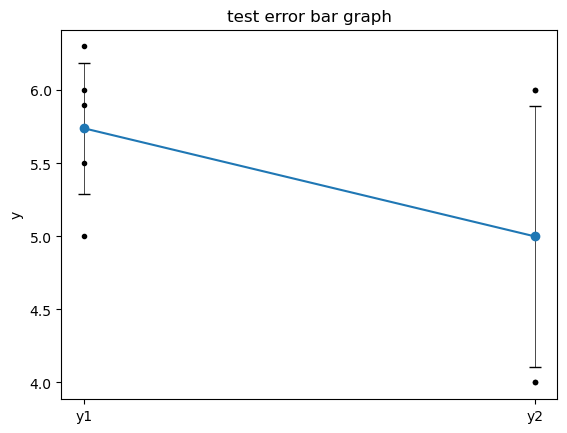

In [48]:
x = ['y1','y2']
y1 = [5.5,6,6.3,5.9,5]
y2 = [4,4,6,6,5]
plt.errorbar(x,[np.mean(y1),np.mean(y2)],yerr=[np.std(y1),np.std(y2)],fmt='o-',ecolor='k',elinewidth=0.5, capsize=4)
plt.title('test error bar graph')
plt.ylabel('y')
plt.plot(x,[y1,y2],'ko',ms=3)

plt.show()

In [34]:
print(np.std(y))

0.8944271909999159


In [3]:
import pandas

In [11]:
data = [4,5,6,4,7]
index = range(1,len(data)+1)
#col = ['a','b','c','d','e']
df = pandas.DataFrame(data,index=index,columns=['a'])
print(df)

   a
1  4
2  5
3  6
4  4
5  7


In [15]:
df.to_csv('test_csv.csv')

In [16]:
read=pandas.read_csv('test_csv.csv')
print(read)

   Unnamed: 0  a
0           1  4
1           2  5
2           3  6
3           4  4
4           5  7


In [18]:
print(read.a)

0    4
1    5
2    6
3    4
4    7
Name: a, dtype: int64


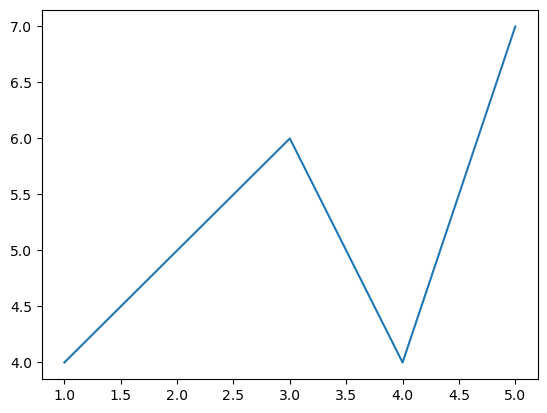

In [19]:
plt.plot(index,read.a)
plt.show()